In [1]:
IS_COLAB = True

In [2]:
#Logic to mount drive if colab

if IS_COLAB:
    from google.colab import drive

    drive.mount('/content/drive')
    %ls
    %cd drive/MyDrive/dsmp-2024-groupol1/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
drive/  sample_data/
/content/drive/MyDrive/dsmp-2024-groupol1


In [3]:
import pandas as pd
df = pd.read_csv('./data/vdjdb.txt', sep="\t")

selected_features = df[['gene','cdr3','v.segm','j.segm','species','mhc.a','mhc.b','mhc.class','antigen.epitope','antigen.species','vdjdb.score']]

# Select all human data
human_data = selected_features[(selected_features['species'] == 'HomoSapiens') & (selected_features['vdjdb.score'] > 0)]

# Drop duplicate rows
human_data = human_data.drop_duplicates()

# Delete rows with null values
human_data  = human_data.dropna()
# Print all data
human_data.head()


,gene,cdr3,v.segm,j.segm,species,mhc.a,mhc.b,mhc.class,antigen.epitope,antigen.species,vdjdb.score
0,TRA,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,HIV-1,2
1,TRB,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,HIV-1,2
2,TRB,CASSFEAGQGFFSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,HIV-1,2
3,TRA,CAVPSGAGSYQLTF,TRAV20*01,TRAJ28*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,HIV-1,2
4,TRB,CASSFEPGQGFYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,HIV-1,2


In [4]:
TRB = human_data[human_data['gene'] =='TRB']
# rename the columns for our beta chain matrix calculation
beta_chains = TRB[['cdr3', 'v.segm', 'j.segm', 'antigen.epitope']]
beta_chains.rename(columns={'cdr3':'cdr3_b_aa','v.segm':'v_b_gene', 'j.segm':'j_b_gene'}, inplace=True)
beta_chains

<ipython-input-4-cdd9bf07a97a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beta_chains.rename(columns={'cdr3':'cdr3_b_aa','v.segm':'v_b_gene', 'j.segm':'j_b_gene'}, inplace=True)


,cdr3_b_aa,v_b_gene,j_b_gene,antigen.epitope
1,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,FLKEKGGL
2,CASSFEAGQGFFSNQPQHF,TRBV13*01,TRBJ1-5*01,FLKEKGGL
4,CASSFEPGQGFYSNQPQHF,TRBV13*01,TRBJ1-5*01,FLKEKGGL
6,CASSYEPGQVSHYSNQPQHF,TRBV13*01,TRBJ1-5*01,FLKEKGGL
8,CASSALASLNEQFF,TRBV14*01,TRBJ2-1*01,FLKEKGGL
...,...,...,...,...
92682,CASSLRATDTQYF,TRBV7-2*01,TRBJ2-3*01,PQPELPYPQPQL
92684,CATSRAGGGGEKLFF,TRBV15*01,TRBJ1-4*01,FPQPEQPFPWQP
92686,CASSQGSGGNEQFF,TRBV4-3*01,TRBJ2-1*01,FPQPEQPFPWQP
92690,CASSIVGSGGYNEQFF,TRBV19*01,TRBJ2-1*01,QLQPFPQPELPY


In [5]:
#install necessary libraries for distance and dimensionality reduction tasks
!pip install tcrdist3
!pip install umap-learn
!pip install umap-learn[plot]

In [6]:
import os
from tcrdist.repertoire import TCRrep
import umap
import umap.plot
import matplotlib.pyplot as plt

def calculate_dist_and_umap(df: pd.DataFrame,
                            chain: str,
                            gene: str) -> pd.DataFrame:
  """
  function which calculates the T-Cell pairwise distance metric by alpha or beta
  chain using TCR dist and then uses UMAP to reduce dimensionality and outputs a
  plot coloured by epitope.
  """

  tr = TCRrep(cell_df = df,
            organism = 'human',
            chains = [chain],
            db_file = 'alphabeta_gammadelta_db.tsv')

  if chain == 'beta':
    distance_matrix = pd.concat([pd.DataFrame(tr.pw_cdr3_b_aa), tr.clone_df[gene]], axis = 1)
  elif chain == 'alpha':
    distance_matrix = pd.concat([pd.DataFrame(tr.pw_cdr3_a_aa), tr.clone_df[gene]], axis = 1)

  value_counts_antigen = distance_matrix[gene].value_counts()
  top_10_value_counts = value_counts_antigen.nlargest(7)
  distance_matrix_filtered = distance_matrix[distance_matrix[gene].isin(top_10_value_counts.index)]

  distances_reduced = umap.UMAP(n_components = 2, n_neighbors = 100, metric='hellinger').fit(distance_matrix_filtered.iloc[:, :-1].values)

  output_dir = 'visualisations'

  f = umap.plot.points(distances_reduced, labels=distance_matrix_filtered[gene])
  f.set_xlabel('UMAP Dimension 1', fontsize=10)
  f.set_ylabel('UMAP Dimension 2', fontsize=10)
  f.set_title(f'UMAP Visualization of {chain}', fontsize=12)

  # Save the figure
  if not os.path.exists(output_dir):
    os.makedirs(output_dir)

  f.get_figure().savefig(f'{output_dir}/{chain}_chain_umap.png')
  return distance_matrix

/usr/local/lib/python3.10/dist-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


/usr/local/lib/python3.10/dist-packages/tcrdist/repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
/usr/local/lib/python3.10/dist-packages/tcrdist/repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")
/usr/local/lib/python3.10/dist-packages/tcrdist/repertoire.py:792: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.cell_df['count'] = 1


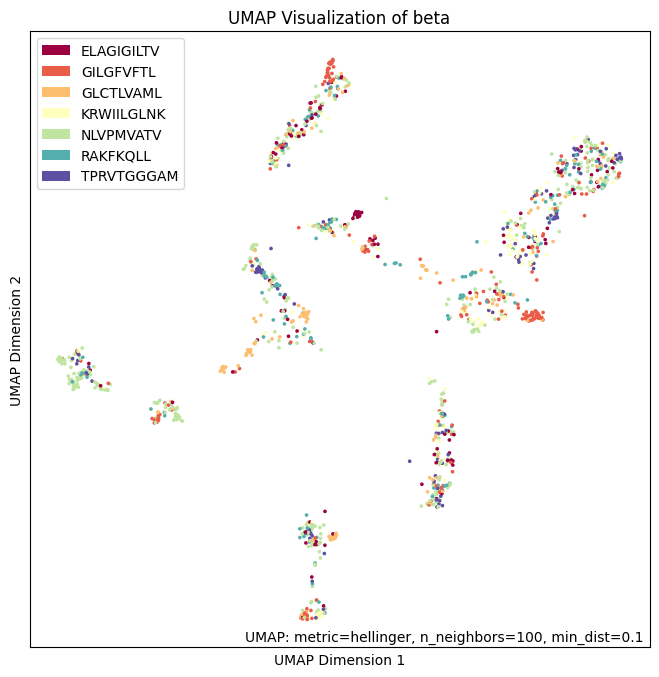

In [7]:
beta_dist_matrix = calculate_dist_and_umap(beta_chains, 'beta', 'antigen.epitope')

Index(['cdr3_a_aa', 'v_a_gene', 'j_a_gene', 'antigen.epitope'], dtype='object')


/usr/local/lib/python3.10/dist-packages/tcrdist/repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
/usr/local/lib/python3.10/dist-packages/tcrdist/repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")


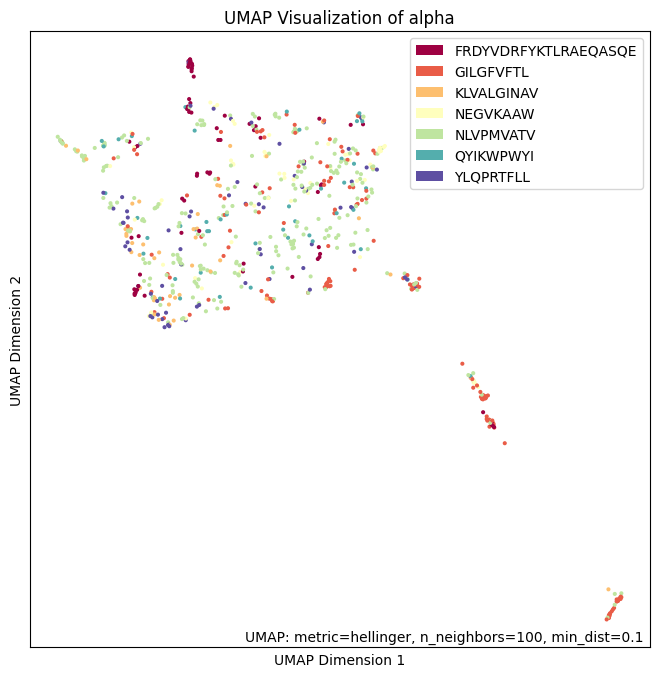

In [8]:
#prepare alpha chain and then input to function
TRA = human_data[human_data['gene'] =='TRA']
alpha_chains = TRA[['cdr3', 'v.segm', 'j.segm', 'antigen.epitope']].copy()
alpha_chains.rename(columns={'cdr3':'cdr3_a_aa','v.segm':'v_a_gene', 'j.segm':'j_a_gene'}, inplace=True)
alpha_df = calculate_dist_and_umap(alpha_chains, 'alpha', 'antigen.epitope')

# Embeddings using pretrained transformer

In [9]:
#move to GPU (if available)

import torch
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [10]:
#instantiate model as pretrained transformer

from transformers import BertModel, BertTokenizer
model_name = 'wukevin/tcr-bert'
model = BertModel.from_pretrained(model_name, add_pooling_layer=False).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


## Helper functions to get embedding from pretrained BERT model


In [11]:
from typing import  Sequence, Any
from math import floor


#special tokens
PAD = "$"
MASK = "."
UNK = "?"
SEP = "|"
CLS = "*"

def is_whitespaced(seq: str) -> bool:
    """
    function to evaluate if sequence has whitespace,
    if not adds whitespace between characterrs
    """
    tok = list(seq)
    spaces = [t for t in tok if t.isspace()]
    if len(spaces) == floor(len(seq) / 2):
        return True
    return False

def get_pretrained_bert_tokenizer(path: str):
    """Get the pretrained BERT tokenizer from given path"""
    tok = BertTokenizer.from_pretrained(
        path,
        do_basic_tokenize=False,
        do_lower_case=False,
        tokenize_chinese_chars=False,
        unk_token=UNK,
        sep_token=SEP,
        pad_token=PAD,
        cls_token=CLS,
        mask_token=MASK,
        padding_side="right",
    )
    return tok

def chunkify(x: Sequence[Any], chunk_size: int = 128):
    """
    Returns the sequence chunks
    """
    retval = [x[i : i + chunk_size] for i in range(0, len(x), chunk_size)]
    return retval

def insert_whitespace(seq: str) -> str:
    return " ".join(list(seq))

In [12]:
model_tokenizer = get_pretrained_bert_tokenizer(model_name)

In [13]:
chains = beta_chains['cdr3_b_aa'].tolist()

 Here we compute a forward pass of the model and extract the embedding representation outputted by the final layer by computing the mean embedding across the first axis. Existing literature suggests that for the TRR-DIST model, that the layer chosen to extract the embedding representation is not important and that embedding representation will be similar across layers. We default to using the final layer

In [34]:
from itertools import zip_longest
import numpy as np


#obtain embedding representation from last hidden layer
layers = [-1]

seqs = [s if is_whitespaced(s) else insert_whitespace(s) for s in chains]


chunks = chunkify(seqs, 1)
chunks_pair = [None]
chunks_zipped = list(zip_longest(chunks, chunks_pair))
embeddings = []


#compute forward pass of model
with torch.no_grad():
      for seq_chunk in chunks_zipped:
          #tokenize input sequence
          encoded = model_tokenizer(
              *seq_chunk, padding="max_length", max_length=64, return_tensors="pt"
          )
          input_mask = encoded["attention_mask"].numpy()
          #move input to GPU
          encoded = {k: v.to(device) for k, v in encoded.items()}
          #forward pass
          x = model.forward(**encoded, output_hidden_states=True, output_attentions=True)
          for i in range(len(seq_chunk[0])):
                e = []
                for l in layers:
                    # Select the l-th hidden layer for the i-th example
                    h = (x.hidden_states[l][i].cpu().numpy().astype(np.float64))
                    if seq_chunk[1] is None:
                      seq_len = len(seq_chunk[0][i].split())
                    seq_hidden = h[1 : 1 + seq_len]
                    e.append(seq_hidden.mean(axis=0))

                e = np.hstack(e)
                assert len(e.shape) == 1
                embeddings.append(e)

#convert to np
if len(embeddings[0].shape) == 1:
    embeddings = np.stack(embeddings)
else:
    embeddings = np.vstack(embeddings)


# UMAP Dimensionality Reduction of TCR BERT

We reduce the dimensionality of the embeddings obtained from pretrained bidirectional encoder using UMAP and then visualise by antigen specificity. Want to see if embedding of t cells which bind to specific antigens are closely related and if clusters more distinct than using tcr dist

(1502, 769)


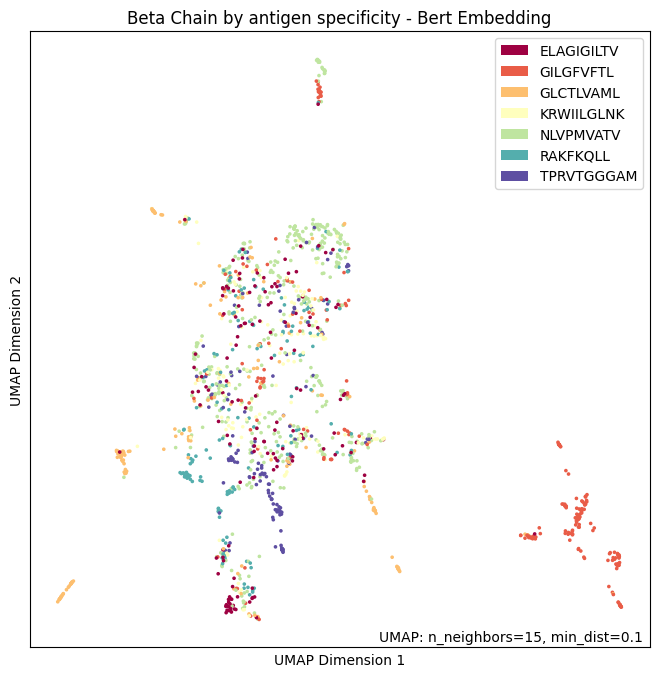

In [22]:
beta_chains.reset_index(inplace= True)
#concatenate embeddings with antigens
embedding_df = pd.concat([pd.DataFrame(embeddings), beta_chains['antigen.epitope']], axis = 1)
value_counts_antigen = embedding_df['antigen.epitope'].value_counts()
#we will only visualise the top 7 most commonly occuring antigens in dataset else visualisation would be uninterpretable
top_10_value_counts = value_counts_antigen.nlargest(7)
embedding_df_filtered = embedding_df[embedding_df['antigen.epitope'].isin(top_10_value_counts.index)]
distances_reduced = umap.UMAP(n_components = 2).fit(embedding_df_filtered.iloc[:, :-1].values)
distances_reduced

## Plot
output_dir = 'visualisations'
f = umap.plot.points(distances_reduced, labels=embedding_df_filtered['antigen.epitope'])
f.set_xlabel('UMAP Dimension 1', fontsize=10)
f.set_ylabel('UMAP Dimension 2', fontsize=10)
f.set_title(f'Beta Chain by antigen specificity - Bert Embedding', fontsize=12)
f.get_figure().savefig(f'{output_dir}/beta_chain_umap_bert.png')


# PCA and then TSNE

Given the high dimensionality of both the distance matrix and embedding representation, reducing dimensions using TSNE is computationally unfeasible. However we can apply PCA to reduce the dimensionality to 50, and then compute TSNE on this reduce representation. This of interest since one of the main advantages of TSNE is that it preserves local distance very effectively which makes it effective for downstream clustering/predictive task

In [38]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


#reducing embeddings from 768 to the 50 components which preserve the most variance in the dataset
PCA_model = PCA(n_components = 50)
embedding_pca = PCA_model.fit_transform(embedding_df.iloc[:, :-1].values)
#apply TSNE on 50 components.
TSNE_model = TSNE(n_components=2, perplexity=30.0)
embedding_pca_tsne = TSNE_model.fit_transform(embedding_pca)




In [39]:
#similar preprocessing to obtain final low dimensional representation of TSNE embedding representation
embedding_tsne_df = pd.DataFrame(np.concatenate((embedding_pca_tsne, embedding_df['antigen.epitope'].values.reshape(-1, 1)),
                                                axis =1),
                                 columns = ['DIM_1', 'DIM_2', 'Epitope'])

epitope_val_count = embedding_tsne_df['Epitope'].value_counts()
top_10_value_counts = epitope_val_count.nlargest(7)
embedding_tsne_filtered = embedding_tsne_df[embedding_tsne_df['Epitope'].isin(top_10_value_counts.index)]

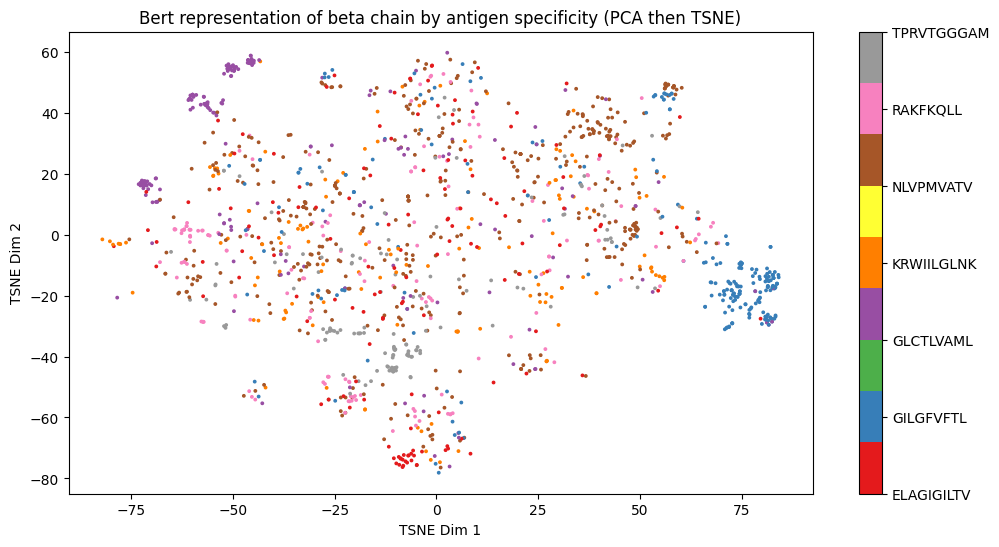

In [40]:
import matplotlib
import matplotlib.pyplot as plt

#plot by antigen spec -> have to obtain numerical representations of antigens to visualise
#in this way
plt.figure(figsize=(12, 6))
epitope_category = pd.Categorical(embedding_tsne_filtered['Epitope'])
epitope_codes = epitope_category.codes
epitope_labels = epitope_category.categories
colormap = matplotlib.colormaps.get_cmap('Set1')

sc = plt.scatter(embedding_tsne_filtered['DIM_1'],
                 embedding_tsne_filtered['DIM_2'],
                 c=epitope_codes,
                 s=3,
                 cmap = colormap)

cbar = plt.colorbar(sc, ticks=np.arange(len(epitope_labels)))
cbar.set_ticklabels(epitope_labels)


plt.xlabel('TSNE Dim 1')
plt.ylabel('TSNE Dim 2')
plt.title('Bert representation of beta chain by antigen specificity (PCA then TSNE)')
plt.savefig(f'{output_dir}/beta_chain_tsne_pca.png')
plt.show()

# Distances for paired alpha and beta pairs

In [ ]:
# Let's get all the IDs for the TCRs (A & B pairs should have the same ID)
_ids = human_data['complex.id']
_ids

list_to_combine = []
checked_ids = []
def process_row(row):
    # check the complex id not already checked
    if row['complex.id'] not in checked_ids:
        # find matching rows
        matched_rows = human_data[human_data['complex.id'] == row['complex.id']]
        # should be two (some rows have only 1 match)
        if len(matched_rows) == 2:
            # get the tcra row
            tra_row = matched_rows.iloc[0]
            # get the tcrb row
            trb_row = matched_rows.iloc[1]
            # add to list as a combined row
            list_to_combine.append({'tcr_id_a':tra_row['complex.id'], 'tcr_id_b':trb_row['complex.id'],
                                    'cdr3_a_aa': tra_row['cdr3'], 'cdr3_b_aa': trb_row['cdr3'],
                                    'v_b_gene' :trb_row['v.segm'],
                                    'j_b_gene':trb_row['j.segm'],
                                    'v_a_gene':tra_row['v.segm'],
                                    'j_a_gene':tra_row['j.segm'],
                                   })
            # we've checked this id now, so we need to make sure we don't have to check it again.
            checked_ids.append(row['complex.id'])
human_data.apply(process_row, axis=1)

In [ ]:
# Create table representing paired tcr rows
paired_table = pd.DataFrame(list_to_combine)
paired_table

# Get paired distances

tr_paired = TCRrep(cell_df = paired_table,
            organism = 'human',
            chains = ['alpha','beta'],
            db_file = 'alphabeta_gammadelta_db.tsv')

# get alpha chain distance calculations for paired tcrs and print them.
paired_matrix_alpha_chain = tr_paired.pw_alpha
paired_alpha_distances = pd.DataFrame(paired_matrix_alpha_chain)
paired_alpha_distances

# get beta chain distance calculations for paired tcrs and print them.
paired_matrix_beta_chain = tr_paired.pw_beta
paired_beta_distances = pd.DataFrame(paired_matrix_beta_chain)
paired_beta_distances